# Support Vector Machine (SVM) and Fuzzy SVM Comparison

This notebook implements and compares two machine learning classifiers:

- **Standard Support Vector Machine (SVM)**: A widely used supervised learning model that finds the optimal separating hyperplane between classes by maximizing the margin between support vectors.
- **Fuzzy Support Vector Machine (Fuzzy SVM)**: An extension of the standard SVM that introduces a *fuzzy membership* value for each sample, reducing the influence of noisy or less reliable data points during training.

We evaluate both methods on synthetic datasets using different kernel functions (linear, polynomial, RBF) to observe how they perform under similar conditions.

The goal of this comparison is to highlight the practical differences between the two approaches, especially in terms of training time and sensitivity to noise.


In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.svm import SVC
import time
from sklearn.datasets import make_moons
import itertools
import warnings
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

###Kernels

Below are three functions implementing different SVM kernels:

- `linear_kernel(x_i, x_j, gamma, deg, r)`  
  Implements the linear kernel, which returns the dot product of two vectors `x_i` and `x_j`.

- `rbf_kernel(x_i, x_j, gamma, deg, r)`  
  Implements the RBF (Radial Basis Function) kernel, calculated using the Gaussian function:  
  $$\exp\left(-\gamma \|x_i - x_j\|^2\right)$$

- `poly_kernel(x_i, x_j, gamma, deg, r)`  
  Implements the polynomial kernel, which returns:  
$$\gamma \cdot \langle x_i, x_j \rangle + r)^{deg}$$

In [ ]:
def linear_kernel(x_i, x_j, gamma, deg, r):
    return np.dot(x_i, x_j)

def rbf_kernel(x_i, x_j, gamma, deg, r):
    return np.exp(-gamma * np.dot(x_i - x_j, x_i - x_j))

def poly_kernel(x_i, x_j, gamma, deg, r):
    return (gamma * np.dot(x_i, x_j) + r) ** deg

###SVM
Here is a basic implementation of Support Vector Machine (SVM) classifier with custom kernels.


In [ ]:
def cost_function(lambdas, y, K):
    n = len(y)
    result = 0
    for i in range(n):
        for j in range(n):
            result += lambdas[i] * lambdas[j] * y[i] * y[j] * K[i, j]
    result = np.sum(lambdas) - 0.5 * result
    return -result

In [ ]:
def SVM(X, y, kernel, gamma=None, deg=3, r=0, c=1):

    n_samples, n_features = X.shape
    if gamma == None:
        gamma = 1 / (n_features* X.var())

    K = np.zeros(shape=(n_samples, n_samples))

    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = kernel(X[i], X[j], gamma, deg, r)

    initial_lambdas = np.random.rand(n_samples)
    bounds = [(0, c)] * n_samples #lambday z przedziału (0,c)
    constraints = {'type': 'eq', 'fun': lambda lambdas, y: np.dot(y, lambdas), 'args': (y,)} #iloczyn lambdy z etykietą równy 0

    solution = minimize(cost_function, initial_lambdas, args=(y, K), bounds=bounds, constraints=constraints)

    lambdas = solution.x
    sv = (lambdas > 1e-5) & (lambdas <= c)
    sv_x = X[sv]
    sv_y = y[sv]
    sv_lambda = lambdas[sv]
    sv_index = np.arange(len(lambdas))[sv]

    b = 0
    for i in range(len(sv_y)):
        b += sv_y[i]
        b -= np.sum(sv_lambda * sv_y * K[sv_index[i], sv])

    b = b/len(sv_lambda)

    if kernel == linear_kernel:
        w = np.zeros(n_features)
        for i in range(len(sv_lambda)):
            w += sv_lambda[i] * sv_x[i] * sv_y[i]
        return sv_x, sv_y, sv_lambda, b, w

    w = None
    return sv_x, sv_y, sv_lambda, b, w

### Fuzzy SVM (FSVM) vs Standard SVM

This implementation extends the standard SVM by incorporating **fuzzy membership values** for each training sample. The main idea is to give different importance (weights) to different samples, which is useful in handling noisy or uncertain data.

---

#### Key Differences and Changes:

1. **Membership weights:**  
   FSVM introduces a `membership` array, assigning a weight to each training sample representing its "importance" or "reliability." Samples with lower membership contribute less to the optimization.

2. **Modified cost function:**  
   The original cost function is adapted to weight the contribution of each pair of samples by the product of their membership values:  
   \[
   \sum_{i,j} \text{membership}_i \times \text{membership}_j \times \lambda_i \lambda_j y_i y_j K_{ij}
   \]
   and the linear term is weighted by `membership` as well:
   \[
   \sum_i \text{membership}_i \times \lambda_i
   \]

3. **SVM training (`FSVM` function):**  
   - Accepts an additional `membership` parameter (default is all ones, which reduces FSVM to standard SVM).
   - Passes the membership values to the cost function during optimization.
   - The rest of the optimization, support vector selection, and calculation of bias and weights remain the same as in the standard SVM.

---

### Summary

- FSVM is more robust to noisy data by down-weighting less reliable samples.
- The main implementation change is in the cost function where membership values modulate the impact of each training point.
- All other parts (kernel computation, optimization constraints, support vector extraction) stay largely unchanged.


In [ ]:
def Fcost_function(lambdas, y, K, membership):
    n = len(y)
    result = 0
    for i in range(n):
        for j in range(n):
            result += membership[i] * membership[j] * lambdas[i] * lambdas[j] * y[i] * y[j] * K[i, j]
    result = np.sum(membership * lambdas) - 0.5 * result
    return -result

In [ ]:
def FSVM(X, y, kernel, gamma=None, deg=3, r=0, c=1, membership=None):
    n_samples, n_features = X.shape
    if gamma is None:
        gamma = 1 / (n_features * X.var())

    if membership is None:
        membership = np.ones(n_samples)

    K = np.zeros(shape=(n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = kernel(X[i], X[j], gamma, deg, r)

    initial_lambdas = np.random.rand(n_samples)
    bounds = [(0, c)] * n_samples
    constraints = {'type': 'eq', 'fun': lambda lambdas, y: np.dot(y, lambdas), 'args': (y,)}

    solution = minimize(
        Fcost_function,
        initial_lambdas,
        args=(y, K, membership),
        bounds=bounds,
        constraints=constraints
    )

    lambdas = solution.x
    sv = (lambdas > 1e-5) & (lambdas <= c)
    sv_x = X[sv]
    sv_y = y[sv]
    sv_lambda = lambdas[sv]
    sv_index = np.arange(len(lambdas))[sv]

    b = 0
    for i in range(len(sv_y)):
        b += sv_y[i]
        b -= np.sum(sv_lambda * sv_y * K[sv_index[i], sv])

    b = b / len(sv_lambda)

    if kernel == linear_kernel:
        w = np.zeros(n_features)
        for i in range(len(sv_lambda)):
            w += sv_lambda[i] * sv_x[i] * sv_y[i]
        return sv_x, sv_y, sv_lambda, b, w

    w = None
    return sv_x, sv_y, sv_lambda, b, w

In [ ]:
def pred(X, sv_x, sv_y, sv_lambda, b, kernel, w=None, gamma=None, deg=3, r=0, c=1):
    n_samples, n_features = X.shape
    if gamma is None:
        gamma = 1 / (n_features * X.var())

    if kernel == linear_kernel:
        return np.sign(np.dot(X, w) + b)
    else:
        y_predict = np.zeros(len(X))
        for k in range(len(X)):
            for lam, x_sv, y_sv in zip(sv_lambda, sv_x, sv_y):
                y_predict[k] += lam * y_sv * kernel(X[k], x_sv, gamma, deg, r)
        return np.sign(y_predict + b)

###Synthetic data

In [ ]:
X, y = make_classification(n_samples=150, n_features=2, n_informative=2, n_redundant=0,
                            n_clusters_per_class=1, random_state=254468)
y[y == 0] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=254468)

###Training

In [ ]:
#SVM
start_svm = time.time()
sv_x_svm, sv_y_svm, sv_lambda_svm, b_svm, we_svm = SVM(X_train, y_train, kernel=linear_kernel)
end_svm = time.time()

y_pred_svm = pred(X_test, sv_x_svm, sv_y_svm, sv_lambda_svm, b_svm, kernel=linear_kernel, w=we_svm)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print(f'SVM training time: {end_svm - start_svm:.4f}')

SVM training time: 33.1356


In [ ]:
#FUZZYSVM
np.random.seed(42)
membership_train = np.random.uniform(0.5, 1.0, len(X_train))

start_fsvm = time.time()
sv_x_fsvm, sv_y_fsvm, sv_lambda_fsvm, b_fsvm, we_fsvm = FSVM(X_train, y_train, kernel=linear_kernel, membership=membership_train)
end_fsvm = time.time()

y_pred_fsvm = pred(X_test, sv_x_fsvm, sv_y_fsvm, sv_lambda_fsvm, b_fsvm, kernel=linear_kernel, w=we_fsvm)
accuracy_fsvm = accuracy_score(y_test, y_pred_fsvm)

print(f'Fuzzy SVM training time: {end_fsvm - start_fsvm:.4f}')

Fuzzy SVM training time: 47.8028


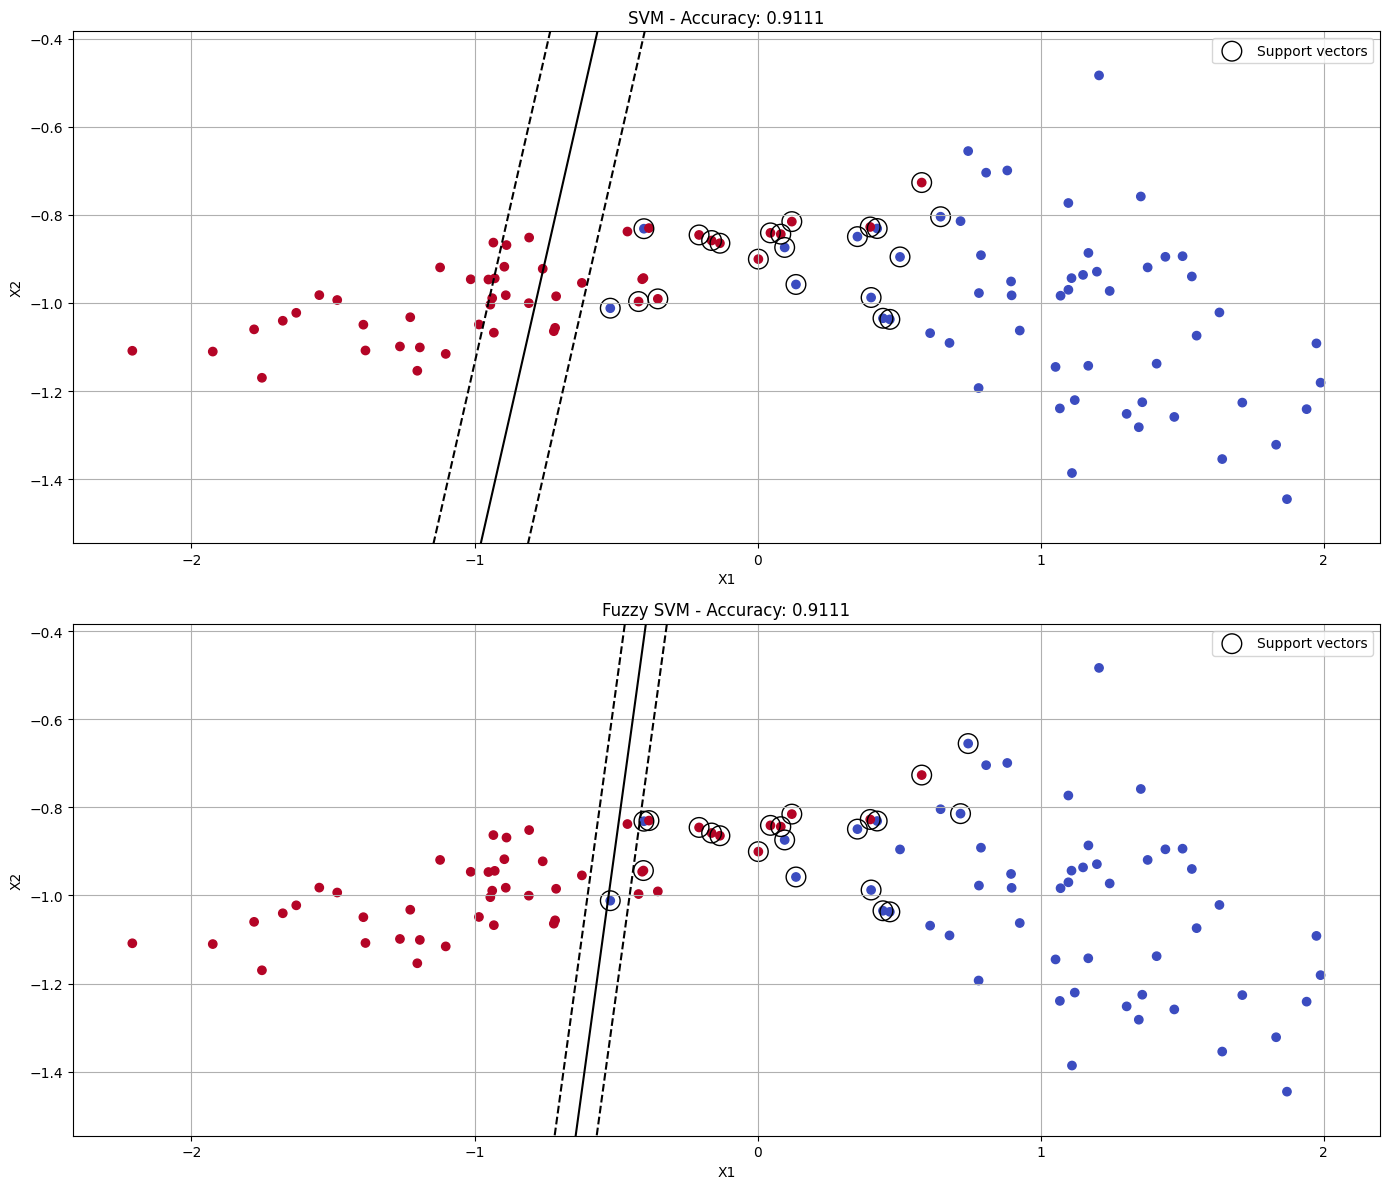

In [ ]:
x0 = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)

x1_fsvm = -(we_fsvm[0] * x0 - b_fsvm) / we_fsvm[1]
margin_x1_fsvm = x1_fsvm + 1 / np.sqrt(np.sum(we_fsvm ** 2))
margin_x2_fsvm = x1_fsvm - 1 / np.sqrt(np.sum(we_fsvm ** 2))

x1_svm = -(we_svm[0] * x0 - b_svm) / we_svm[1]
margin_x1_svm = x1_svm + 1 / np.sqrt(np.sum(we_svm ** 2))
margin_x2_svm = x1_svm - 1 / np.sqrt(np.sum(we_svm ** 2))

y_min = np.min(X[:, 1]) - 0.1
y_max = np.max(X[:, 1]) + 0.1

plt.figure(figsize=(14, 12))

plt.subplot(2, 1, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm')
plt.plot(x0, x1_svm, 'black')
plt.plot(x0, margin_x1_svm, 'k--')
plt.plot(x0, margin_x2_svm, 'k--')
plt.scatter(sv_x_svm[:, 0], sv_x_svm[:, 1], s=200, facecolors='none', edgecolors='k', label='Support vectors')
plt.title(f'SVM - Accuracy: {accuracy_svm:.4f}')
plt.xlabel('X1')
plt.ylabel('X2')
plt.ylim(y_min, y_max)
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm')
plt.plot(x0, x1_fsvm, 'black')
plt.plot(x0, margin_x1_fsvm, 'k--')
plt.plot(x0, margin_x2_fsvm, 'k--')
plt.scatter(sv_x_fsvm[:, 0], sv_x_fsvm[:, 1], s=200, facecolors='none', edgecolors='k', label='Support vectors')
plt.title(f'Fuzzy SVM - Accuracy: {accuracy_fsvm:.4f}')
plt.xlabel('X1')
plt.ylabel('X2')
plt.ylim(y_min, y_max)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

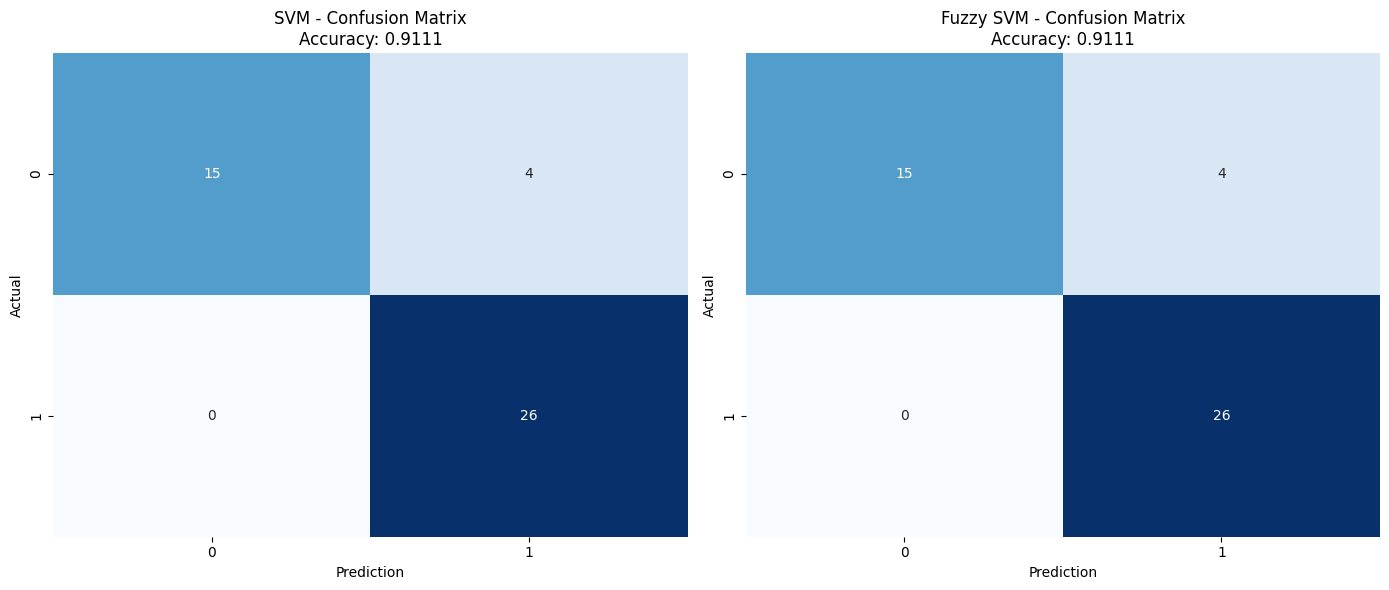

In [ ]:
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
conf_matrix_fsvm = confusion_matrix(y_test, y_pred_fsvm)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'SVM - Confusion Matrix\nAccuracy: {accuracy_svm:.4f}')
plt.xlabel('Prediction')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_fsvm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Fuzzy SVM - Confusion Matrix\nAccuracy: {accuracy_fsvm:.4f}')
plt.xlabel('Prediction')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


Now lets try **RBF Kernel**

In [ ]:
def calculate_decision_boundary(X, sv_x, sv_y, sv_lambda, b, kernel, gamma=None, deg=3, r=1):
    if gamma is None:
        gamma = 1 / sv_x.shape[1]
    Z = np.zeros(len(X))
    for k in range(len(X)):
        for lam, x_sv, y_sv in zip(sv_lambda, sv_x, sv_y):
            Z[k] += lam * y_sv * kernel(X[k], x_sv, gamma, deg, r)
    return Z + b

In [ ]:
X, y = make_moons(n_samples=100, random_state=254468)
y[y == 0] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=254468)

In [ ]:
start_svm = time.time()
sv_x_svm, sv_y_svm, sv_lambda_svm, b_svm, we_svm = SVM(X_train, y_train, kernel=rbf_kernel)
end_svm = time.time()

y_pred_svm = pred(X_test, sv_x_svm, sv_y_svm, sv_lambda_svm, b_svm, kernel=rbf_kernel, w=we_svm)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print(f'SVM training time: {end_svm - start_svm:.4f}')

SVM training time: 62.5748


In [ ]:
np.random.seed(42)
membership_train = np.random.uniform(0.5, 1.0, len(X_train))

start_fsvm = time.time()
sv_x_fsvm, sv_y_fsvm, sv_lambda_fsvm, b_fsvm, we_fsvm = FSVM(X_train, y_train, kernel=rbf_kernel, membership=membership_train)
end_fsvm = time.time()

y_pred_fsvm = pred(X_test, sv_x_fsvm, sv_y_fsvm, sv_lambda_fsvm, b_fsvm, kernel=rbf_kernel, w=we_fsvm)
accuracy_fsvm = accuracy_score(y_test, y_pred_fsvm)

print(f'Fuzzy SVM training time: {end_fsvm - start_fsvm:.4f}')

Fuzzy SVM training time: 50.8592


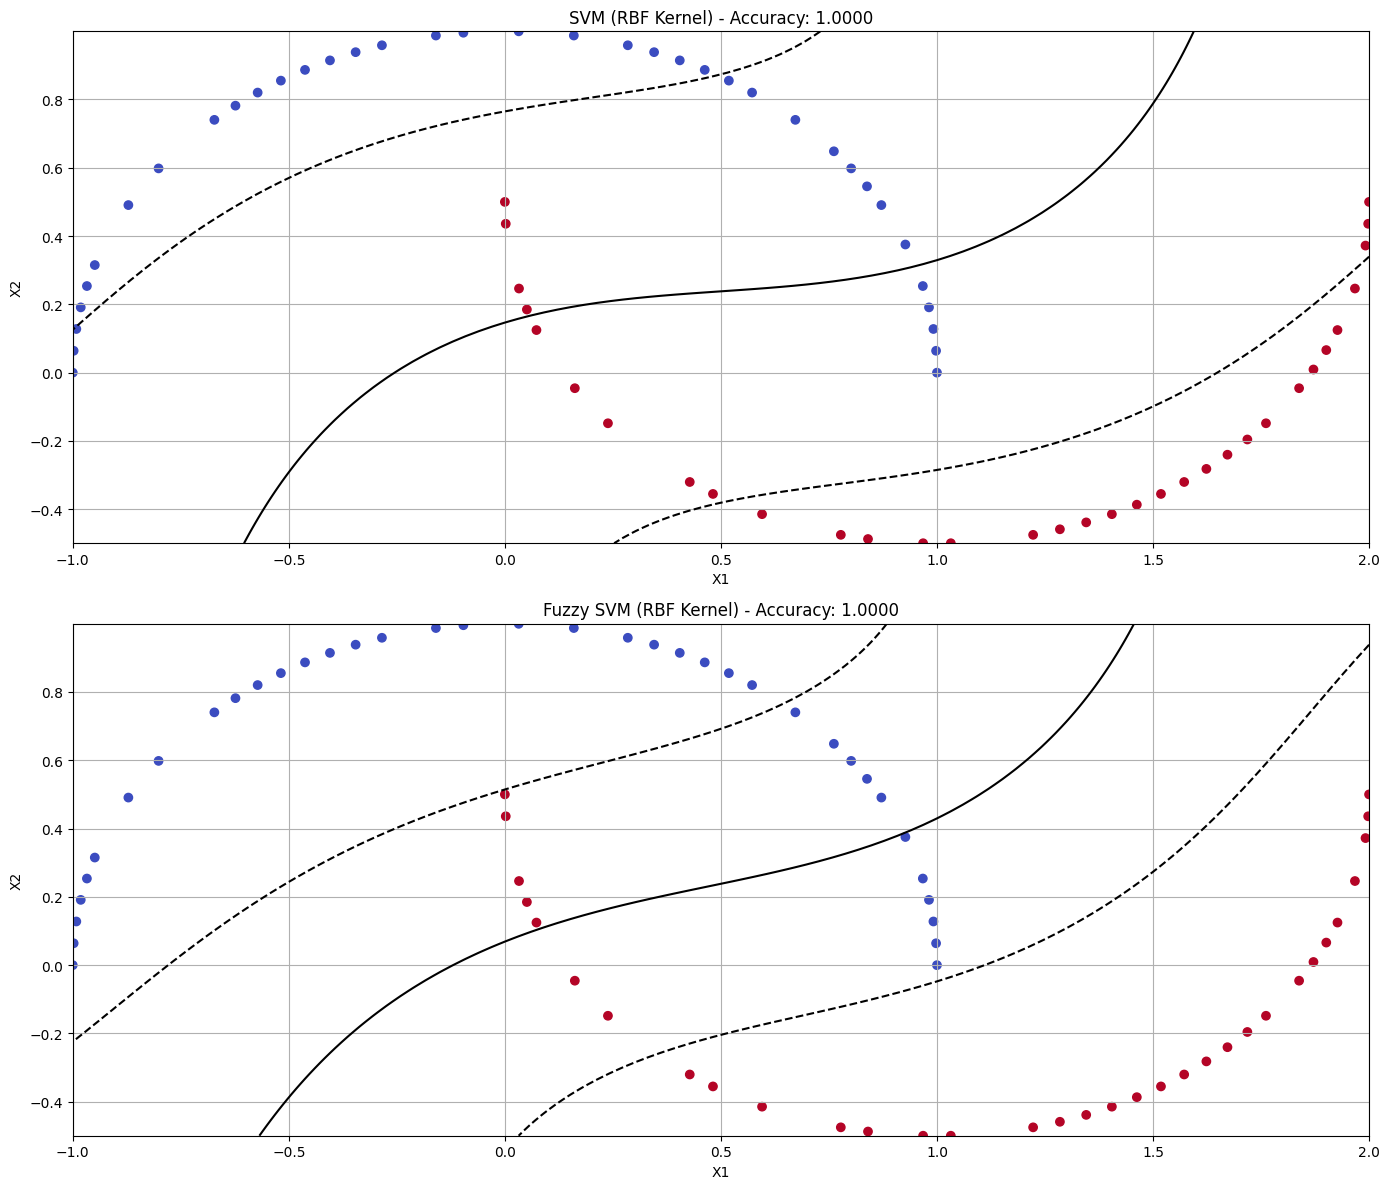

In [ ]:
x0 = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
x1 = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), 100)
X0, X1 = np.meshgrid(x0, x1)
XX = np.array([X0.ravel(), X1.ravel()]).T

Z_svm = calculate_decision_boundary(XX, sv_x_svm, sv_y_svm, sv_lambda_svm, b_svm, rbf_kernel)
Z_svm = Z_svm.reshape(X0.shape)

Z_fsvm = calculate_decision_boundary(XX, sv_x_fsvm, sv_y_fsvm, sv_lambda_fsvm, b_fsvm, rbf_kernel)
Z_fsvm = Z_fsvm.reshape(X0.shape)

plt.figure(figsize=(14, 12))

plt.subplot(2, 1, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm')
plt.contour(X0, X1, Z_svm, levels=[-1, 0, 1], colors='k', linestyles=['--', '-', '--'])
plt.title(f'SVM (RBF Kernel) - Accuracy: {accuracy_svm:.4f}')
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm')
plt.contour(X0, X1, Z_fsvm, levels=[-1, 0, 1], colors='k', linestyles=['--', '-', '--'])
plt.title(f'Fuzzy SVM (RBF Kernel) - Accuracy: {accuracy_fsvm:.4f}')
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)

plt.tight_layout()
plt.show()


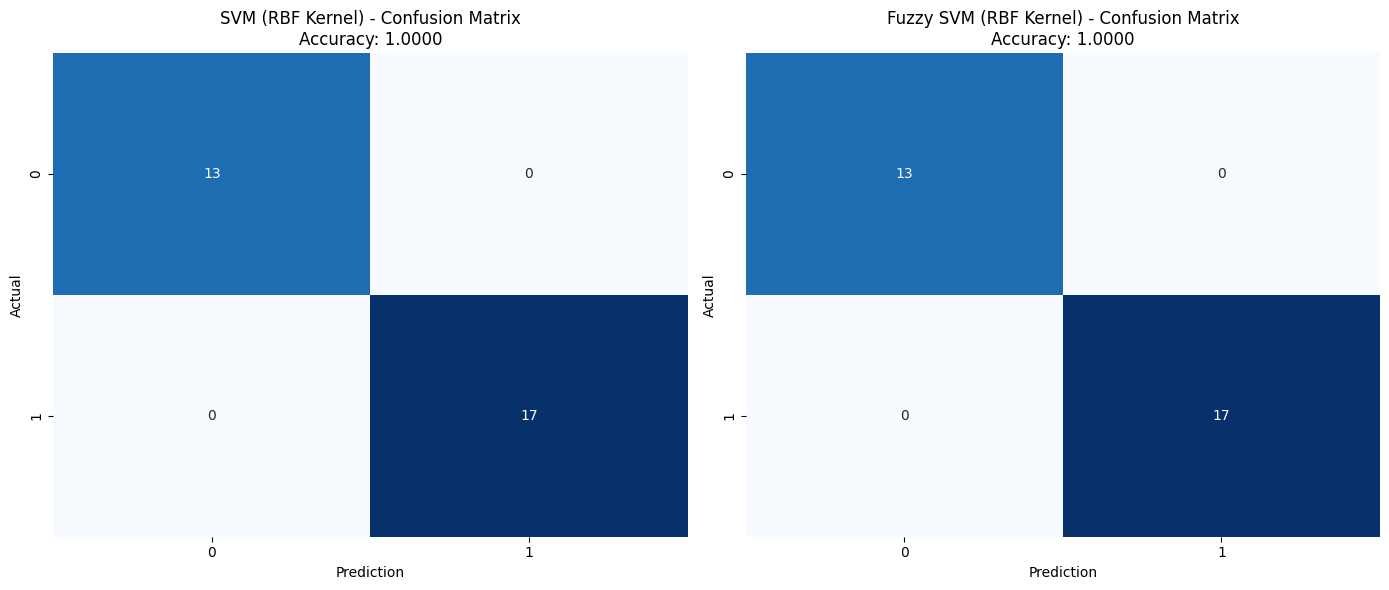

In [ ]:
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
conf_matrix_fsvm = confusion_matrix(y_test, y_pred_fsvm)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'SVM (RBF Kernel) - Confusion Matrix\nAccuracy: {accuracy_svm:.4f}')
plt.xlabel('Prediction')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_fsvm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Fuzzy SVM (RBF Kernel) - Confusion Matrix\nAccuracy: {accuracy_fsvm:.4f}')
plt.xlabel('Prediction')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

### Summary
After testing on two synthetic datasets using two different kernels, we observe that both classic SVM and Fuzzy SVM perform similarly in terms of classification quality. However, Fuzzy SVM takes significantly longer to train due to the additional computations involving membership weights. Nonetheless, FSVM can be more valuable when dealing with noisy or uncertain data.
